<a href="https://colab.research.google.com/github/rafaelguariento/R_useful/blob/main/reactive_pest_use.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import scipy.integrate
import os
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
# --------------------------- Model -----------------------------------------------------

def lotka_volterra(t, uVec, paramDic):
    s, r, v, c = uVec
    dudtVec = np.zeros_like(uVec)
    dudtVec[0] = paramDic['rS']*(1 - (s - paramDic['cRS'] * r)/paramDic['k']) * (1-paramDic['dD']*c) * s - paramDic['dS']*s
    dudtVec[1] = paramDic['rR']*(1 - (r + paramDic['cSR'] * s)/paramDic['k'])*r - paramDic['dR']*r
    dudtVec[2] = paramDic['theta']*(dudtVec[0] + dudtVec[1])
    dudtVec[3] = 0
    return (dudtVec)

In [ ]:
# --------------------------- Simulation -----------------------------------------------------
def Simulate_pestice_max(initialStateVec,paramDic,modelFun,t_end=None,t_span=None,t_eval=None,nTimePts=100,**kwargs):
    t_span = t_span if t_span is not None else (0, t_end)
    t_eval = t_eval if t_eval is not None else np.linspace(t_span[0],t_span[1],nTimePts)
    solObj = scipy.integrate.solve_ivp(lambda t, uVec: modelFun(t,uVec,paramDic), y0=initialStateVec,
                                       t_span=t_span,t_eval=t_eval,**kwargs)
    return pd.DataFrame({"Time": solObj.t, "S": solObj.y[0, :], "R": solObj.y[1, :],
                              "V":solObj.y[2,:], "D": solObj.y[3, :]})

def Simulate_non_int_fixed_target(initialStateVec,paramDic,modelFun,
                               atThreshold=0.5,intervalLength=3,refSize=None,t_end=None,t_span=None,t_eval=None,nTimePts=100,**kwargs):
    t_span = t_span if t_span is not None else (0, t_end)
    t_eval = t_eval if t_eval is not None else np.linspace(0,t_end,nTimePts)
    resultsDFList = []
    currInterval = [t_span[0],t_span[0]+intervalLength]
    refSize = initialStateVec[2] if refSize is None else refSize
    dose = initialStateVec[-1]
    currCycleId = 0
    while currInterval[1] <= t_end: 
        # Simulate
        resultsDf = Simulate_pestice_max(initialStateVec,modelFun=modelFun,
                                         paramDic=paramDic,
                                         t_span=(currInterval[0], currInterval[1]),
                                         t_eval=np.linspace(currInterval[0], currInterval[1],1000))
        resultsDf['CycleId'] = currCycleId
        resultsDFList.append(resultsDf)

        # Update dose
        if resultsDf.V.iat[-1] > refSize:
            currCycleId += (dose==0)
            dose = paramDic['DMax']
        elif resultsDf.V.iat[-1] < (1-atThreshold)*refSize:
            dose = 0
        else:
            dose = (dose > 0)*paramDic['DMax']
        initialStateVec = [resultsDf.S.iat[-1], resultsDf.R.iat[-1], resultsDf.V.iat[-1], dose]

        # Update interval
        currInterval = [x+intervalLength for x in currInterval]
    resultsDf = pd.concat(resultsDFList)
    # Interpolate to the desired time grid
    trimmedResultsDic = {'Time':t_eval}
    for variable in ['S','R','V','D','CycleId']:
        f =  scipy.interpolate.interp1d(resultsDf.Time,resultsDf[variable],fill_value="extrapolate")
        trimmedResultsDic = {**trimmedResultsDic,variable:f(t_eval)}
    return pd.DataFrame(data=trimmedResultsDic)
# Format plot
sns.set(style="white",
        font_scale=1.5,
        font="Serif",
        rc={'figure.figsize':(12,6)})



In [ ]:
# --------------------------- Parameter Functions -----------------------------------------------------

def GenerateParameterDic(initialSize,rFrac,cost,turnover,paramDic):
    """
    Generate parameter dictionary for given initial conditions, cost and turnover values.
    :param cost:
    :param turnover:
    :param paramDic:
    :return:
    """
    # Generate ICS
    initialStateVec = [initialSize * (1 - rFrac), initialSize * rFrac, 0, paramDic['DMax']]
    initialStateVec[2] = paramDic['theta'] * (initialStateVec[0] + initialStateVec[1])

    # Generate params
    paramDic = paramDic.copy()
    paramDic['rR'] = (1-cost)*paramDic['rS']
    paramDic['dR'] = turnover*paramDic['rS']
    paramDic['dS'] = turnover*paramDic['rS']
    return initialStateVec,paramDic



# Define the parameters
paramDic = {"rS":.027, "rR":.027, "cRS":1., "cSR":1.,"dD":1.5, 
            "k":1., "D":0, "theta":1, 'DMax':1.}
paramDic['dR'] = 0.2*paramDic['rR']
paramDic['dS'] = 0.2*paramDic['rS']
nTimePts = 100
dt = 1.
intervalLength = 1
rFracPalette = {0.001:sns.xkcd_rgb['coral'],0.01:sns.xkcd_rgb['scarlet'],0.1:sns.xkcd_rgb['dark red']}



In [ ]:


def PlotDifferentATThresholds(model,initialTumourSize,sFrac,tEnd=1000,atThresholdList=[.5,1.],
                              paramDic=paramDic,
                              nTimePts = 100, intervalLength = 1,
                              drugBarPosition = 1., drugBarWidth=.05,
                              ylim=1.2,y2lim=1.2,
                              lineStyleDic = {'1.0':'-','0.75':'--','0.5':'-.','0.3':'--'},
                              colorDic = {'1.0':(1,148/255,9/255),'0.75':sns.xkcd_rgb['dark teal'],'0.5':'#094486','0.3':sns.xkcd_rgb['aqua']},
                              figsize=(12,8),ax=None,**kwargs):
    if ax is None: fig, ax = plt.subplots(1,1,sharex=True,sharey=True,figsize=figsize)
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    initialStateVec = [initialTumourSize*sFrac,initialTumourSize*(1-sFrac),0,paramDic['DMax']]
    initialStateVec[2] = paramDic['theta']*(initialStateVec[0] + initialStateVec[1])

    # Simulate AT
    for i,atThreshold in enumerate(atThresholdList):
        resultsDf = Simulate_non_int_fixed_target(modelFun=model,
                                               initialStateVec=initialStateVec,
                                               atThreshold=atThreshold,intervalLength=intervalLength,
                                               paramDic=paramDic,
                                               t_end=tEnd, t_eval=np.linspace(0,tEnd,nTimePts))
        ttp_AT = resultsDf.Time[resultsDf.V > 1.2*initialTumourSize].min()
        ax.plot(resultsDf.Time,
                resultsDf.V,
                lw=kwargs.get('linewidthA', 4), color=colorDic[str(atThreshold)],
                linestyle=lineStyleDic[str(atThreshold)], marker=kwargs.get('markerA', None),
                label=kwargs.get('labelA', 'Model Prediction'))
        currDrugBarPosition = drugBarPosition+i*drugBarWidth
        drugConcentrationVec = resultsDf.D.values*(drugBarWidth-1e-3)+currDrugBarPosition
        ax2.fill_between(resultsDf.Time,
                         currDrugBarPosition, drugConcentrationVec, color=colorDic[str(atThreshold)],
                         alpha=1., label="Drug Concentration")
        ax.vlines(x=ttp_AT,ymin=0,ymax=1.2,color=colorDic[str(atThreshold)],
                  linestyles=lineStyleDic[str(atThreshold)],linewidth=3)

    # Format the plot
    ax.set_ylim([0,ylim])
    ax2.set_ylim([0, y2lim])
    ax2.axis("off")
    ax.tick_params(labelsize=24)
    if kwargs.get('savefigB', False):
        plt.savefig(kwargs.get('outName', 'modelPrediction.png'), orientation='portrait')  

In [ ]:
# Make directory for figures
if not os.path.isdir("./figures/"):
    os.mkdir("./figures/")


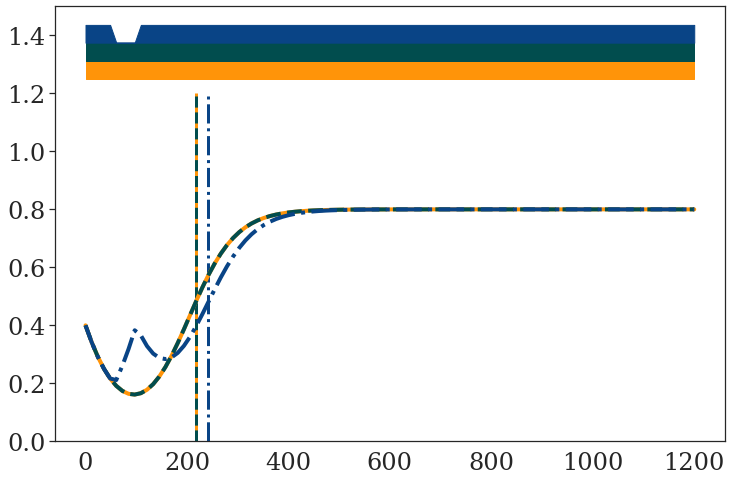

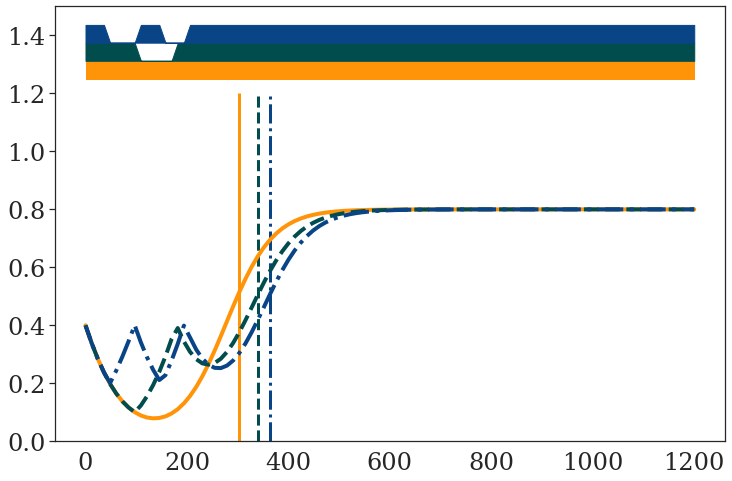

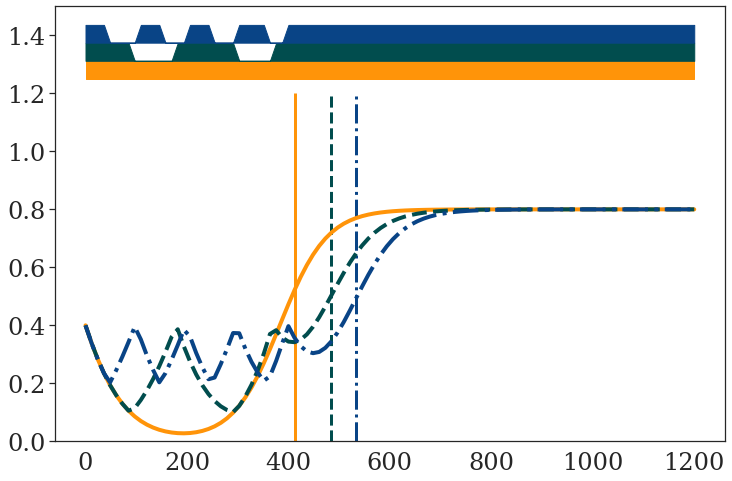

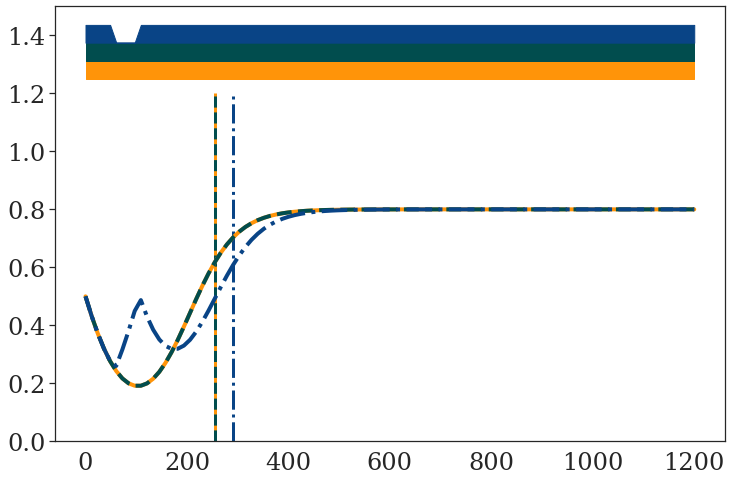

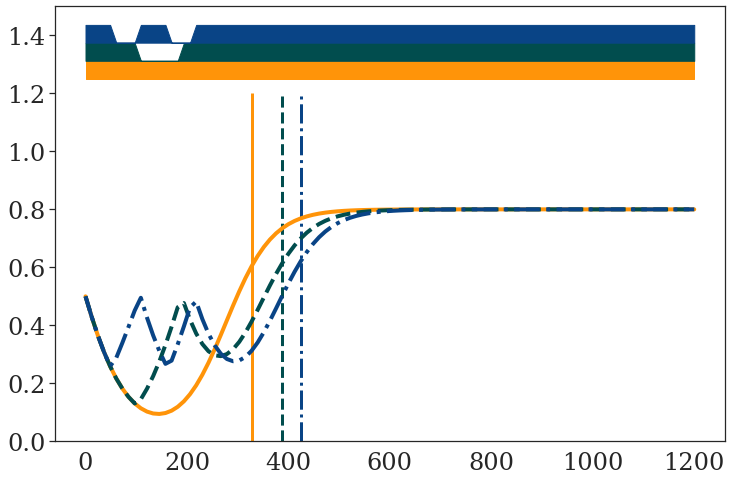

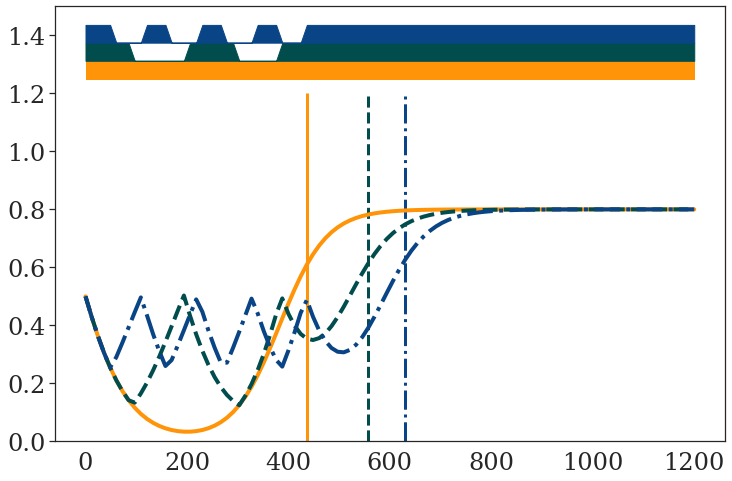

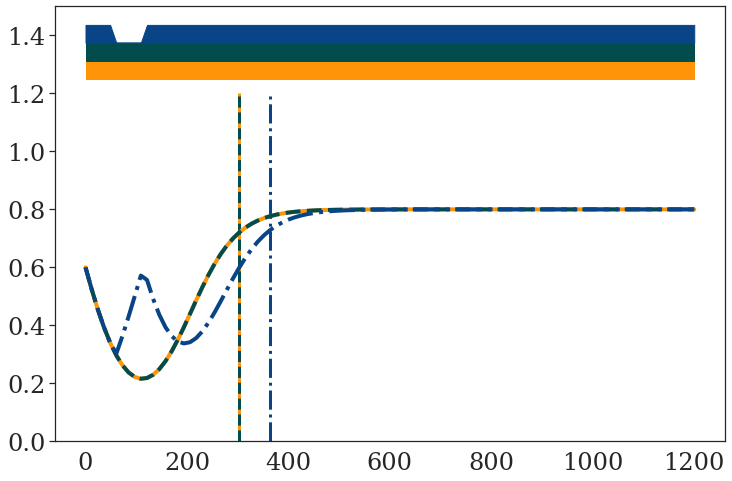

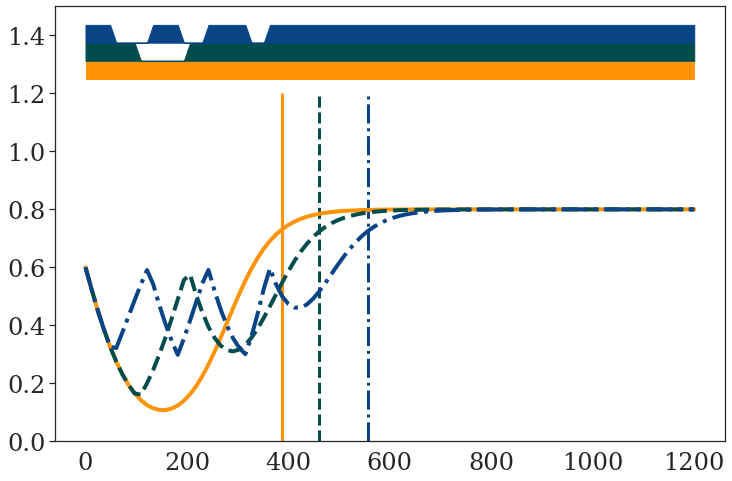

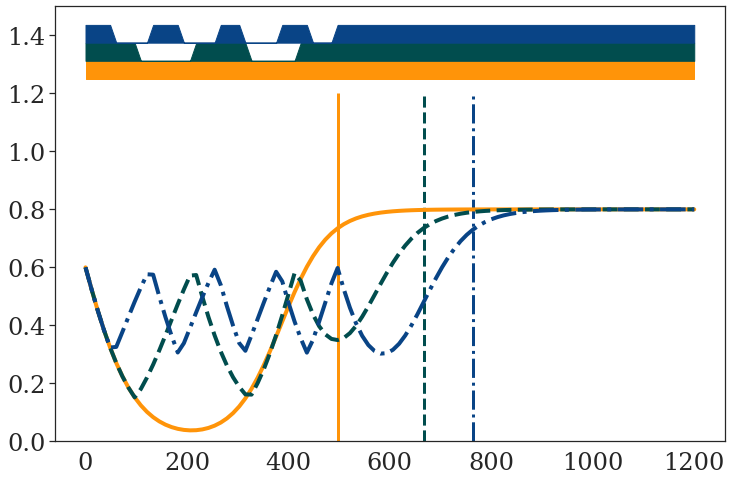

In [ ]:

tEnd = 1200
deathRate = 0.2
cost = 0
atThresholdList = [1.,0.75, 0.5]
currParamDic = paramDic.copy()
currParamDic['dS'] = deathRate*currParamDic['rS']
currParamDic['dR'] = deathRate*currParamDic['rR']
currParamDic['rR'] *= (1-cost)

for i,initialSize in enumerate([x for x in [0.4,0.5,.6]]):
    for j,sFrac in enumerate([0.95,0.99,0.999]):
        PlotDifferentATThresholds(model=lotka_volterra,initialTumourSize=initialSize,tEnd= tEnd, sFrac=sFrac,ylim=1.5,
                          atThresholdList=atThresholdList,paramDic=currParamDic,
                          savefigB=True,outName="figures/timeSeriesPlot_noTurnover_noCost_iS_%1.2f_sFrac_%1.2f.pdf"%(initialSize,sFrac))

                        